# Моделирование капиллярной неравновесности в композитных пористых средах с контрастными капиллярными свойствами

Ниже представлено пошаговое исследование рассматриваемой модели. В идеале нужно придти к системе, в которой мы будем учитывать неравновестные процессы по Кондаурову (капилярная неравновестность) и Хассанизаде (неравновестность, вызванная динамическими эффектами).

In [1]:
import numpy as np
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import pandas as pd
from scipy.optimize import minimize, root_scalar

from scipy.linalg import block_diag, solve

import json

In [2]:
class Environment_properties():
    def __init__(self, phi, w, n, alpha):
        '''Create properties for environment
        
        param phi: porosity
        param w: share in environment
        param n: Van Genuchten n
        param alpha: Van Genuchten alpha [Pa^{-1}]
        '''
        self.phi = phi
        self.w = w
        self.n = n
        self.alpha = alpha

In [25]:
# porosity of loam sand and sand via http://geophys.geol.msu.ru/shevnin/publ/174.pdf
# Van Genuchten params via https://www.researchgate.net/figure/Soil-parameters-for-the-Van-Genuchten-equation-for-seven-different-soil-textures_tbl1_42976119
sand = Environment_properties(phi=0.09, w=0.8, n=2.474, alpha=0.380*1e+3)
loamy_sand = Environment_properties(phi=0.3, w=0.2, n=1.672, alpha=0.837*1e+3)
# sandy_loam = Environment_properties(phi=0.15, w=0.5, n=1.553, alpha=0.396*1e+3)
# loamy_sand = sandy_loam

######## Van Genuchten model ########
p1ref, p2ref = 1/loamy_sand.alpha, 1/sand.alpha # [Pa]
n1, n2 = loamy_sand.n, sand.n
m1, m2 = 1-1/n1, 1-1/n2  # m = 1 - 1/n
#####################################

# dinamic viscosity [Pa * sec]
# for two selected crude oils
mu_w = 1000e-6  #19.1#1e-6 https://www.sciencedirect.com/science/article/pii/S0920410505001129 http://www.ajer.org/papers/v3(3)/O033113120.pdf (crude oils)
mu_nw = 5.48e-3  #24.4e-3  #298.7#1004e-6  #5*mu_w

# permeability for 1st enviroment [m^2] where filtration goes
# via https://www.researchgate.net/publication/281892878_Investigation_of_Fault_Permeability_in_Sands_with_Different_Mineral_Compositions_Evaluation_of_Gas_Hydrate_Reservoir
K0 = (3.51+1.8)*1e-13
# via https://www.sciencedirect.com/science/article/pii/S1110016816302083
# we obtain mean permeability (!hydralic conductivity) [m / sec] for sands
# as a liquid take water rho accordingly to mu_w
# K0 = 3.86e-3  # [m/sec]
# rho_liquid =  1000 # [kg/m^3]
# g = 9.81  # [m/sec^2]
# K0 = 1/(rho_liquid*g) * mu_w  # is it ok?
print('permeability for 1st environment =', K0, '[m^2]')

######## Noneqilibrium params ########
K = 1  # ~ (dp/dS)^{-1}
tau_k = 0.9
tau_h = 0
######################################

p_a = 1000*1e+6  #?

# porosity
phi1, phi2 = loamy_sand.phi, sand.phi
w1, w2 = loamy_sand.w, sand.w
assert w1 + w2 == 1, 'w1 + w2 have to equal 1'
r = (w2*phi2) / (w1*phi1)# 1  # w2 phi2 / w1 phi1
phi = w1*phi1 + w2*phi2  # ?!
print('r   = {:.2f}'.format(r), '\nphi = {:.2f}'.format(phi))

T, L = 1, 1  # problem [0, T] x [0, L]
n_T, n_L = 10000, 400
t_list = np.linspace(0, T, n_T)#t_list = np.linspace(0, T, 100000)
h_list = np.linspace(0, L, n_L)
dt, dh = T/n_T, L/n_L

sign = 1  # related to the question, after integral (solved)

permeability for 1st environment = 5.31e-13 [m^2]
r   = 1.20 
phi = 0.13


In [4]:
def S1(S, ksi):
    eq = (1+r)*S - r*(1-ksi)
#     if eq < 0:
#         return 0.0001
#     if eq > 1:
#         return 0.9999
    return eq


def S2(ksi):
    return 1 - ksi

def p_c1(S1):
    return sign*phi1*p1ref*(S1**(-1/m1) - 1)**(1/n1)

def p_c2(S2):
    return sign*phi2*p2ref*(S2**(-1/m2) - 1)**(1/n2)

def dksi_dt(t, ksi, S):
    ''' The 3d equation of our system '''
    
    if ((ksi == 0 or S1(S, ksi) == 0) and (p_c1(S1(S, ksi)) < p_c2(S2(ksi)))) or \
        ((S1(S, ksi) == 1 or ksi == 1) and p_c1(S1(S, ksi)) > p_c2(S2(ksi))):
        return 0
    return K/tau_k * (p_c1(S1(S, ksi)) - p_c2(S2(ksi)))
#     return 0

def k_rw(S1):
    return S1**2

def k_rn(S1):
    return (1-S1)**2

def lamb_w(S1):
    return k_rw(S1)*K0/mu_w

def lamb_nw(S1):
    return k_rn(S1)*K0/mu_nw

def lamb_sum(S1):
    return lamb_nw(S1) + lamb_w(S1)

def solve_ode(S, ksi0):
    ''' Solve ksi ode via Adams solver.
        Type(S) : function '''
    
    def wrapper(t, ksi):  # remove extra arguments
        return dksi_dt(t, ksi, S(t))
    ODE=ode(wrapper)
    ODE.set_integrator('vode') 
    ODE.set_initial_value(ksi0, 0)
    ksi_list = [ksi0]
    while ODE.successful() and ODE.t < T:
        ksi_list.append(ODE.integrate(ODE.t+dt)[0])
    if len(ksi_list) - len(t_list) == 1:
        ksi_list.pop()
    assert len(ksi_list) == len(t_list), 'Ksi was not resolved correctly via ODE with len ksi_list={}, t_list={}'.format(len(ksi_list), len(t_list))
    return ksi_list
        
def p_c(S1, dksi_dt, dSdt):
    ''' p_c + also Hassanizade '''
    
    eq = p_c1(S1) - tau_h * ((1+r)*dSdt + r*dksi_dt)
#     assert eq >= 0, 'p_c can not be < 0! Check hassanizade eq. part'
    return eq

## Equlibrium equation of $\xi$

In [5]:
def get_ksi_equilibrium(S, t):
    ''' Find ksi in equilibrium process in time: t'''
    def S1(S, ksi):
        ''' !Fictive function of S1! '''     
        eq = (1+r)*S - r*(1-ksi)
        if eq < 0:
            return 0.0001
        if eq > 1:
            return 0.9999
        return eq
    def find_ksi_equilibrium(ksi):
        ''' Equation when dksi/dt=0 '''
        return p_c1(S1(S, ksi)) - p_c2(S2(ksi))
#     plt.plot(np.linspace(0, 1), [find_ksi_equilibrium(ksi) for ksi in np.linspace(0, 1)])
#     plt.title('pc1($\\xi$) - pc2($\\xi$). S = {:.2f}'.format(S))
#     plt.show()
    # # КОСТЫЛИ # #
    if S > 0.99:
        return 0  #0.0001
#     if S < 0.05:
#         return 1  #0.9999
    try:  # if smth wrong with n1,n2,m1,m2 when it is 2 close to zero
        root_fksi = root_scalar(find_ksi_equilibrium, method='brentq', bracket=[0.0001, 0.9999])
    except ValueError:
        return 1
    return root_fksi.root

Text(0.5, 1.0, '$\\xi (S)$ in equlibrium (pc1=pc2)')

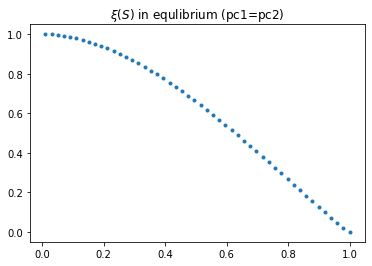

In [6]:
x = np.linspace(0.01, 1)
plt.plot(x, [get_ksi_equilibrium(x_, 0) for x_ in x], '.')
plt.title('$\\xi (S)$ in equlibrium (pc1=pc2)')

# Equation of $\frac{\partial \xi}{\partial t} = f(\xi, S)$ 

In [29]:
def find_ksi_next(t, S_n, ksi_n):
    ''' Нахождение распределения ksi на следующем временном слое
    
    Arguments:
        t : значение предыдущего времени (n-ого)
        S_n: S с предыдущего временного слоя
        ksi_n : -//-
    Method:
        Неявный метод Рунге — Кутты второго порядка
    '''
    
    ksi_predict = ksi_n + dt*dksi_dt(t, ksi_n, S_n)
    iter_n, eps = 0, 10
    while eps > 1e-5 and iter_n < 100:  # the depth of iteration proccess 
        ksi_n1 = ksi_n + dt/2*(dksi_dt(t, ksi_n, S_n) + dksi_dt(t+dt, ksi_predict, S_n))
        eps = np.abs(ksi_n1 - ksi_predict)
        ksi_predict = ksi_n1
        iter_n += 1
        if iter_n > 50:
            print(iter_n, eps)
    return ksi_n1

# Elliptic problem of $P$

In [8]:
def find_P(S_n, P_n, p_c_n, ksi_n1):
    ''' Поиск P на n+1 врменном слое
    
    Arguments
        S_n: прост. распредление S с n временного слоя
        P_n: -//- == [None] если на 0 временном слое
        p_c_n: -//- капилярного давления с n временного слоя (а кси подставлять с n+1?)
        ksi_n1: -//- ksi с n+1 временного слоя 
    Method
        a*x=b
    '''
    def f1(i):
        return S_n[i]*p_c_n[i]
    def f2(i):
        return (1+S_n[i])*p_c_n[i]
    
    # left coeff
    C = block_diag(1)
    B = block_diag(0)
    F = [p_a]
    
    # + coeff_i
    for i in range(1, len(h_list)-1):
        if P_n[0] != None:
            if P_n[i] > P_n[i-1]:  # in opposite to gradient of P
                _temp = S1(S_n[i], ksi_n1[i])
            else:
                _temp = S1(S_n[i-1], ksi_n1[i-1])
            lamb_nw_prev = lamb_nw(_temp)
            lamb_sum_prev = lamb_sum(_temp)
            lamb_w_prev = lamb_w(_temp)
            if P_n[i+1] > P_n[i]:
                _temp = S1(S_n[i+1], ksi_n1[i+1])
            else:
                _temp = _temp = S1(S_n[i], ksi_n1[i])
            lamb_nw_next = lamb_nw(_temp)
            lamb_sum_next = lamb_sum(_temp)
            lamb_w_next = lamb_w(_temp)
#             lamb_w_prev = (lamb_w(S1(S_n[i-1], ksi_n1[i-1]))+lamb_w(S1(S_n[i], ksi_n1[i])))/2
#             lamb_w_next = (lamb_w(S1(S_n[i], ksi_n1[i]))+lamb_w(S1(S_n[i+1], ksi_n1[i+1])))/2
#             lamb_nw_prev = (lamb_nw(S1(S_n[i-1], ksi_n1[i-1]))+lamb_nw(S1(S_n[i], ksi_n1[i])))/2
#             lamb_sum_prev = (lamb_sum(S1(S_n[i-1], ksi_n1[i-1]))+lamb_sum(S1(S_n[i], ksi_n1[i])))/2
#             lamb_nw_next = (lamb_nw(S1(S_n[i], ksi_n1[i]))+lamb_nw(S1(S_n[i+1], ksi_n1[i+1])))/2
#             lamb_sum_next = (lamb_sum(S1(S_n[i], ksi_n1[i]))+lamb_sum(S1(S_n[i+1], ksi_n1[i+1])))/2
        else:
            _temp = S1(S_n[i], ksi_n1[i])
            lamb_nw_prev = lamb_nw(_temp)
            lamb_sum_prev = lamb_sum(_temp)
            lamb_w_prev = lamb_w(_temp)
            _temp = S1(S_n[i+1], ksi_n1[i+1])
            lamb_nw_next = lamb_nw(_temp)
            lamb_sum_next = lamb_sum(_temp)
            lamb_w_next = lamb_w(_temp)
        
        B = block_diag(B,
                       lamb_sum_next)
        if i == 1:
            A = block_diag(lamb_sum_prev)
        else:
            A = block_diag(A, lamb_sum_prev)
        C = block_diag(C,
                       (-lamb_sum_next-lamb_sum_prev))
        F.append(-lamb_nw_next*(f1(i+1) - f1(i)) +
                 lamb_nw_prev*(f1(i) - f1(i-1)) +
                 lamb_w_next*(f2(i+1) - f2(i)) -
                 lamb_w_prev*(f2(i) - f2(i-1))
                )
    # + right coeff
    A = block_diag(A,
                   0)
    C = block_diag(C, 
                   1)
    F.append(0.)
    
    global trash
    trash = F
    
    # составление трехдиагональной матрицы
    A = np.append(np.zeros((1,len(h_list))), np.append(A, np.zeros((len(h_list)-1,1)), axis=1), axis=0)
    B = np.append(np.append(np.zeros((len(h_list)-1, 1)), B, axis=1), np.zeros((1, len(h_list))), axis=0)
    sum_matrix = A+B+C

    return solve(sum_matrix, F)

# Equation of $S$

In [9]:
def dp_c1dS(S_n, ksi_n):
    eps = 1e-7
    return (p_c1(S1(S_n+eps, ksi_n)) - p_c1(S1(S_n-eps, ksi_n)))/(2*eps)

In [10]:
def find_S(t, S_n, P_n, p_c_n, ksi_n):
    ''' Поиск S на n+1 врменном слое, краевая задача
    
    Arguments
        t : время n+1-ого шага
        S_n: прост. распредление S с n временного слоя
        P_n: -//- с n+1 временного слоя
        p_c_n: -//- капилярного давления с n+1 временного слоя (а кси подставлять с n+1?)
        ksi_n: -//- ksi с n+1 временного слоя 
    Method
        a*x=b
    '''
    # support funcs
    def f1(j):
        return 0
#         return  (dp_c1dS(S_n[j], ksi_n[j]) 
#                 - tau_h/dt*(1+r) 
#                 - dp_c1dS(S_n[j], ksi_n[j])*S_n[j] 
#                 + tau_h/dt*(1+r)*S_n[j] 
#                 - p_c1(S1(S_n[j], ksi_n[j])) 
#                 + tau_h*dksi_dt(t, ksi_n[j], S_n[j]))
    def f2(j):
        return 0
#         return (p_c1(S1(S_n[j], ksi_n[j])) 
#                 - tau_h*dksi_dt(t, ksi_n[j], S_n[j]) 
#                 - p_c1(S1(S_n[j], ksi_n[j]))*S_n[j] 
#                 + tau_h*dksi_dt(t, ksi_n[j], S_n[j])*S_n[j])
    
#     global ai_coeff
#     global ci_coeff
#     global bi_coeff
#     global fi_coeff
    
    # left coeff
    C = block_diag(1)
    B = block_diag(0)
    F = [1]
#     ci_coeff.append(1)
#     bi_coeff.append(0)
#     fi_coeff.append(1)
    
    # + coeff_i
    for i in range(1, len(h_list)-1):
        if P_n[i] > P_n[i-1]:  # in opposite to gradient of P
            _temp = S1(S_n[i], ksi_n[i])
        else:
            _temp = S1(S_n[i-1], ksi_n[i-1])
        lamb_nw_prev = lamb_nw(_temp)
        lamb_sum_prev = lamb_sum(_temp)
        lamb_w_prev = lamb_w(_temp)
        if P_n[i+1] > P_n[i]:
            _temp = S1(S_n[i+1], ksi_n[i+1])
        else:
            _temp = _temp = S1(S_n[i], ksi_n[i])
        lamb_nw_next = lamb_nw(_temp)
        lamb_sum_next = lamb_sum(_temp)
        lamb_w_next = lamb_w(_temp)   
        
        B = block_diag(B,
                       1/dh * (lamb_w_next/dh*(f1(i+1))))
        if i == 1:
            A = block_diag(1/dh * (-lamb_w_prev/dh*(-f1(i-1))))
        else:
            A = block_diag(A, 1/dh * (-lamb_w_prev/dh*(-f1(i-1))))
        C = block_diag(C,
                       phi/dt + 1/dh*(lamb_w_next/dh*(-f1(i)) - lamb_w_prev/dh*(f1(i))))
        F.append(1/dh*(lamb_w_next*((P_n[i+1] - P_n[i])/dh - 1/dh*(f2(i+1) - f2(i))) - lamb_w_prev*((P_n[i] - P_n[i-1])/dh - 1/dh*(f2(i) - f2(i-1)))) + \
                 phi/dt*S_n[i] - \
                 1/dh*(lamb_w_next/dh*(-f1(i+1)*S_n[i+1] + f1(i)*S_n[i]) - lamb_w_prev/dh*(-f1(i)*S_n[i] + f1(i-1)*S_n[i-1]))
                )
#         ai_coeff.append(1/dh * (-lamb_w_prev/dh*(-f1(i-1))))
#         bi_coeff.append(1/dh * (lamb_w_next/dh*(f1(i+1))))
#         ci_coeff.append(phi/dt + 1/dh*(lamb_w_next/dh*(-f1(i)) - lamb_w_prev/dh*(f1(i))))
#         fi_coeff.append(1/dh*(lamb_w_next*((P_n[i+1] - P_n[i])/dh - 1/dh*(f2(i+1) - f2(i))) - lamb_w_prev*((P_n[i] - P_n[i-1])/dh - 1/dh*(f2(i) - f2(i-1)))) + \
#                  phi/dt*S_n[i] - \
#                  1/dh*(lamb_w_next/dh*(-f1(i+1)*S_n[i+1] + f1(i)*S_n[i]) - lamb_w_prev/dh*(-f1(i)*S_n[i] + f1(i-1)*S_n[i-1])))

    # + right coeff
#     A = block_diag(A,
#                    -1)
    A = block_diag(A,
                   -1)
    C = block_diag(C, 
                   1)
#     F.append(dt/(dh*phi)*(lamb_w_next/dh*(P_n[-1] - P_n[-2]) - lamb_w_prev/dh*(P_n[-2] - P_n[-3])) + S_n[-1])
#     F.append(0.1)
    F.append(0)
#     ai_coeff.append(0)
#     ci_coeff.append(1)
#     fi_coeff.append(0.1)
    
    # составление трехдиагональной матрицы
    A = np.append(np.zeros((1,len(h_list))), np.append(A, np.zeros((len(h_list)-1,1)), axis=1), axis=0)
    B = np.append(np.append(np.zeros((len(h_list)-1, 1)), B, axis=1), np.zeros((1, len(h_list))), axis=0)
    sum_matrix = A+B+C

    return solve(sum_matrix, F)

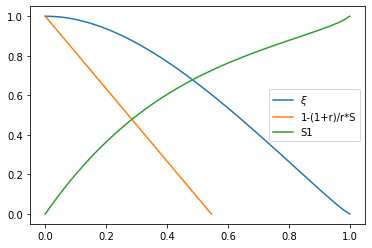

In [11]:
plt.plot(np.linspace(0, 1), [get_ksi_equilibrium(S, 0) for S in np.linspace(0, 1)], label='$\\xi$')
plt.plot(np.linspace(0, r/(1+r)), [1-(1+r)/r*S for S in np.linspace(0,r/(1+r))], label='1-(1+r)/r*S')
plt.plot(np.linspace(0,1), [S1(S, get_ksi_equilibrium(S, 0)) for S in np.linspace(0,1)], label='S1')
plt.legend()

In [21]:
# save 4 report
ksionce_ksi = ksi_list
ksionce_S = S_list

## 4. Учет неравновестности по Кондаурову 
* $\tau_h = 0$ (нет учета неравновестности Hassanizade)
* $p_c \neq 0$
* $\xi$ считается на всех шагах

In [27]:
tau_k = 0.0001 # 0.0055

In [28]:
tau_h = 0

# t = 0
S_list = [[1] + [0.05]*(len(h_list) - 1)]
ksi_list = [[get_ksi_equilibrium(S_list[0][i], 0) for i in range(len(h_list))]]
P_list = [find_P(S_list[0],
                 [None],
                 [p_c(S1(S_list[0][i], ksi_list[0][i]), 0, 0) for i in range(len(h_list))], #[0]*h_list,  #
                 ksi_list[0])]

print('dt = {:e}'.format(dt))
print('p_a = {:e}'.format(p_a))
print('tau_k = {:e}'.format(tau_k))
print('tau_h = {:e}'.format(tau_h))

for t_idx, t in enumerate(tqdm(t_list[1:100])):  # t_idx : предыдущего слоя; t : время на текущем 

#     dsdt = [(S_list[t_idx][i] - S_list[t_idx][i]) / dt for i in range(len(h_list))]
    dsdt = [0]*len(h_list)
    p_c_n = [p_c(S1(S_list[t_idx][i], ksi_list[t_idx][i]), dksi_dt(t, ksi_list[t_idx][i], S_list[t_idx][i]) , dsdt[i]) for i in range(len(h_list))]
    assert not np.iscomplex(p_c_n).any(), 'Комплексное значение в p_c_n'
    
    S_list.append(find_S(t, S_list[t_idx], P_list[t_idx], p_c_n, ksi_list[t_idx]))
    
    ksi_list.append([find_ksi_next(t, S_list[t_idx][i], ksi_list[t_idx][i]) for i in range(len(h_list))])
    
#     # for iteration proc
#     S_n = S_list[-1]
#     S_n1 = S_list[-1]
#     P_n = P_list[-1]
#     eps_l_P, eps_l_S = [], []
#     eps, iterations = 1, 0
#     while eps > 1e-3 and iterations < 100:
#         iterations += 1
        
#         p_c_n = [p_c(S1(S_n[i], ksi_list[t_idx][i]), dksi_dt(t, ksi_list[t_idx][i], S_n[i]) , dsdt[i]) for i in range(len(h_list))]
#         assert not np.iscomplex(p_c_n).any(), 'Комплексное значение в p_c_n'
        
#         P_n1 = find_P(S_n1, P_n, p_c_n, ksi_list[t_idx])
#         eps_l_P.append(np.mean(np.abs(P_n - P_n1)))
        
#         S_n1 = find_S(t, S_n, P_n1, p_c_n, ksi_list[t_idx])
#         eps_l_S.append(np.mean(np.abs(S_n - S_n1)))
        
#         # update n
#         P_n = P_n1
#         S_n = S_n1
        
#         eps = min(eps, max(eps_l_S[-1], eps_l_P[-1]))
#     print(iterations, end=' ')
        
    p_c_n1 = [p_c(S1(S_list[t_idx+1][i], ksi_list[t_idx+1][i]), dksi_dt(t, ksi_list[t_idx+1][i], S_list[t_idx+1][i]) , dsdt[i]) for i in range(len(h_list))]
    assert not np.iscomplex(p_c_n1).any(), 'Комплексное значение в p_c_n'
    
    # what should I use p_c_n or p_c_n1?
    P_n = find_P(S_list[t_idx+1], P_list[t_idx], p_c_n, ksi_list[t_idx+1])
    P_list.append(P_n)

dt = 1.000000e-04
p_a = 1.000000e+09
tau_k = 1.000000e-04
tau_h = 0.000000e+00


51 4.3561038531869656e-07
52 3.790849383289441e-07
53 3.298976927190722e-07
54 2.8709006194560516e-07
55 2.4983909929776615e-07
56 2.1742011602210454e-07
57 1.8920891264873063e-07
58 1.646573942748475e-07
59 1.4329228792409054e-07
60 1.2469892685107453e-07
61 1.0851857368265883e-07
62 9.443743120840509e-08
51 6.020598603551086e-06
52 5.7931156082213775e-06
53 5.574472603075975e-06
54 5.363854935658274e-06
55 5.161404756925947e-06
56 4.966401427775047e-06
57 4.778945409733559e-06
58 4.59839830890818e-06
59 4.4248264325918996e-06
60 4.257663421380897e-06
61 4.09694777070424e-06
62 3.942176288740384e-06
63 3.793364988124992e-06
64 3.6500661385607813e-06
65 3.5122777369833713e-06
66 3.3796008109820974e-06
67 3.2520190784701697e-06
68 3.129176488814167e-06
69 3.0110455978560324e-06
70 2.897308189586667e-06
71 2.7879282499254643e-06
72 2.682620960037241e-06
73 2.581343884422438e-06
74 2.483841725520186e-06
75 2.390067399105078e-06
76 2.299791740378865e-06
77 2.212964473224943e-06
78 2.129379

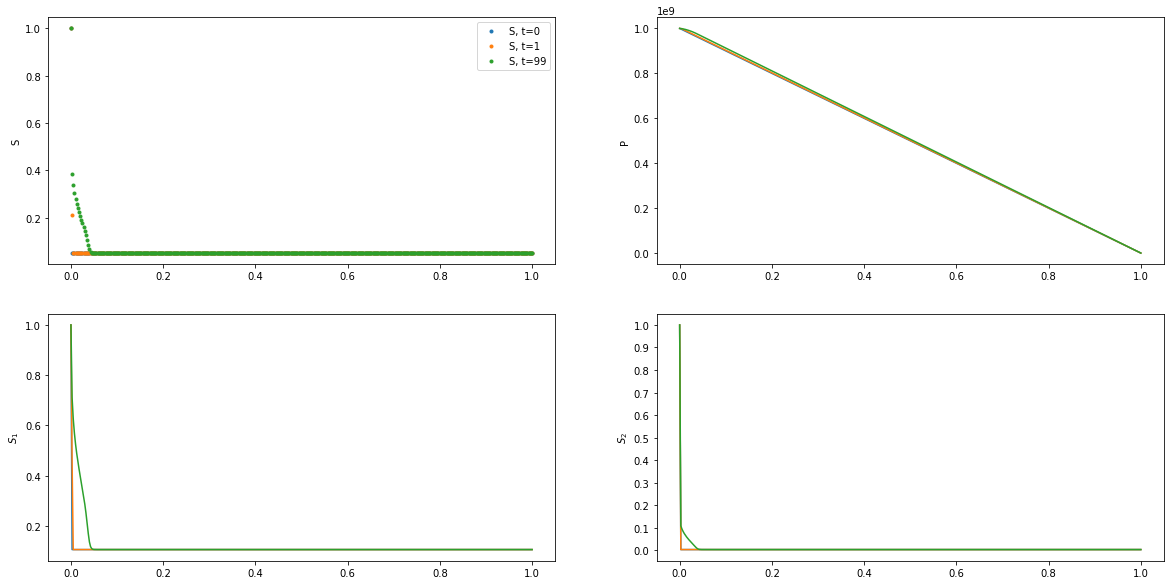

dt = 0.0001
tau_kondaurov = 0.0001


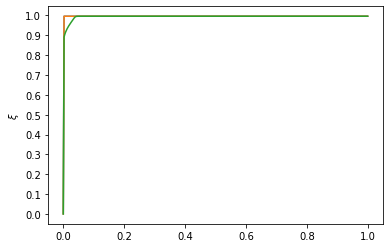

In [31]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
for i in [0, 1, 99, ]:
    ax[0, 0].plot(h_list, S_list[i], '.', label='S, t={}'.format(i))
#     ax[0, 0].scatter(0.2, b_debug, s=30, c='black')
    ax[0, 1].plot(h_list, P_list[i], '-', label='P')
    ax[1, 0].plot(h_list, [S1(S_list[i][j], ksi_list[i][j]) for j in range(len(S_list[i]))])
    ax[1, 1].plot(h_list, [S2(ksi_list[i][j]) for j in range(len(S_list[i]))])
ax[0, 0].set_ylabel('S')
ax[1, 0].set_ylabel('$S_1$')
ax[1, 1].set_ylabel('$S_2$')
ax[1, 1].set_yticks(np.arange(0, 1.1, 0.1))
ax[0, 1].set_ylabel('P')
ax[0, 0].legend()
plt.show()

print('dt = {}'.format(dt))
print('tau_kondaurov =', tau_k)

for i in [0, 1, 99 ]:
    plt.plot(h_list, ksi_list[i])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('$\\xi$')
plt.show()

In [28]:
#save 4 report
kond_ksi = ksi_list
kond_S = S_list

## 5. Учет обеих неравновестностей
Отличительная особенность:
* $\tau_h \neq 0$

In [39]:
# p_a = 10  # left bound
tau_h = 0

# t = 0
S_list = [[1] + [0.05]*(len(h_list) - 1)]
ksi_list = [[get_ksi_equilibrium(S_list[0][i], 0) for i in range(len(h_list))]]
P_list = [find_P(S_list[0],
                 [None],
                 [p_c(S1(S_list[0][i], ksi_list[0][i]), 0, 0) for i in range(len(h_list))], #[0]*h_list,  #
                 ksi_list[0])]

print('dt = {:e}'.format(dt))
print('p_a = {:e}'.format(p_a))
print('tau_k = {:e}'.format(tau_k))
print('tau_h = {:e}'.format(tau_h))

eps_l_P_array = []
eps_l_S_array = []
for t_idx, t in enumerate(tqdm(t_list[1:100])):  # t_idx : предыдущего слоя; t : время на текущем 

    dsdt = [0]*len(h_list)  #[(S_list[t_idx][i] - S_list[t_idx][i]) / dt for i in range(len(h_list))]
    p_c_n = [p_c(S1(S_list[t_idx][i], ksi_list[t_idx][i]), dksi_dt(t, ksi_list[t_idx][i], S_list[t_idx][i]) , dsdt[i]) for i in range(len(h_list))]
    assert not np.iscomplex(p_c_n).any(), 'Комплексное значение в p_c_n'
    
    S_list.append(find_S(t, S_list[t_idx], P_list[t_idx], p_c_n, ksi_list[t_idx]))
    
    ksi_list.append([find_ksi_next(t, S_list[t_idx][i], ksi_list[t_idx][i]) for i in range(len(h_list))])
    
    # for iteration proc
    S_n = S_list[-1]
    S_n1 = S_list[-1]
    P_n = P_list[-1]
    eps_l_P, eps_l_S = [100], [100]
    delta_eps = 100
    eps, iterations = 1, 0
    while eps > 1e-4 and iterations < 100 and not delta_eps < 1e-3:
        dsdt = [(S_list[t_idx+1][i] - S_list[t_idx][i]) / dt for i in range(len(h_list))]
        p_c_n = [p_c(S1(S_n[i], ksi_list[t_idx][i]), dksi_dt(t, ksi_list[t_idx][i], S_n[i]) , dsdt[i]) for i in range(len(h_list))]
        assert not np.iscomplex(p_c_n).any(), 'Комплексное значение в p_c_n'
        
        P_n1 = find_P(S_n1, P_n, p_c_n, ksi_list[t_idx])  # WARNING: почему xi с n слоя, когда в описании к функции n+1?
        eps_l_P.append(np.max(np.abs(P_n - P_n1)))
        
        S_n1 = find_S(t, S_n, P_n1, p_c_n, ksi_list[t_idx])  # WARNING: -//-
        eps_l_S.append(np.max(np.abs(S_n - S_n1)))
        
        eps_l_P_array.append(eps_l_P)
        eps_l_S_array.append(eps_l_S)
        
        # update n
        P_n = P_n1
        S_n = S_n1
        
        eps = min(eps, max(eps_l_S[-1], eps_l_P[-1]))
        delta_eps = max(abs(eps_l_P[-1] - eps_l_P[-2]), abs(eps_l_S[-1] - eps_l_S[-2]))
        print(delta_eps)
#         print(delta_eps, eps)
        iterations += 1
    print(iterations, end=' ')
        
#     p_c_n1 = [p_c(S1(S_list[t_idx+1][i], ksi_list[t_idx+1][i]), dksi_dt(t, ksi_list[t_idx+1][i], S_list[t_idx+1][i]) , dsdt[i]) for i in range(len(h_list))]
#     assert not np.iscomplex(p_c_n1).any(), 'Комплексное значение в p_c_n'
#     P_n = find_P(S_list[t_idx+1], P_list[t_idx], p_c_n1, ksi_list[t_idx+1])
    P_list.append(P_n)

dt = 1.000000e-04
p_a = 1.000000e+09
tau_k = 1.000000e-04
tau_h = 0.000000e+00


3109574.5716764927
3062954.30165112
10340.073579072952
39943.50627660751
21247.956546902657
6532.880010008812
2439.613879799843
3737.8387076854706
4946.95104598999
3503.9172533750534
1334.491218805313
1046.401648402214
576.0028642416
2481.029165148735
1992.1717956066132
1179.8852095603943


KeyboardInterrupt: 

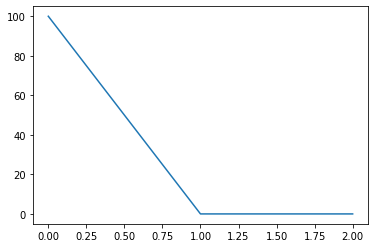

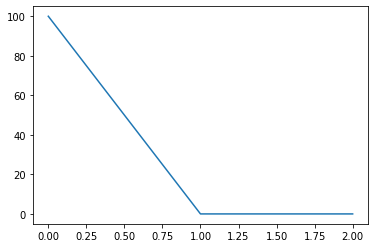

In [30]:
plt.plot(range(len(eps_l_P_array[0])), eps_l_P_array[0])
plt.show()
plt.plot(range(len(eps_l_P_array[-1])), eps_l_P_array[-1])

dt = 0.0001
tau_kondaurov = 0.0001
tau_hassanizade = 0.005


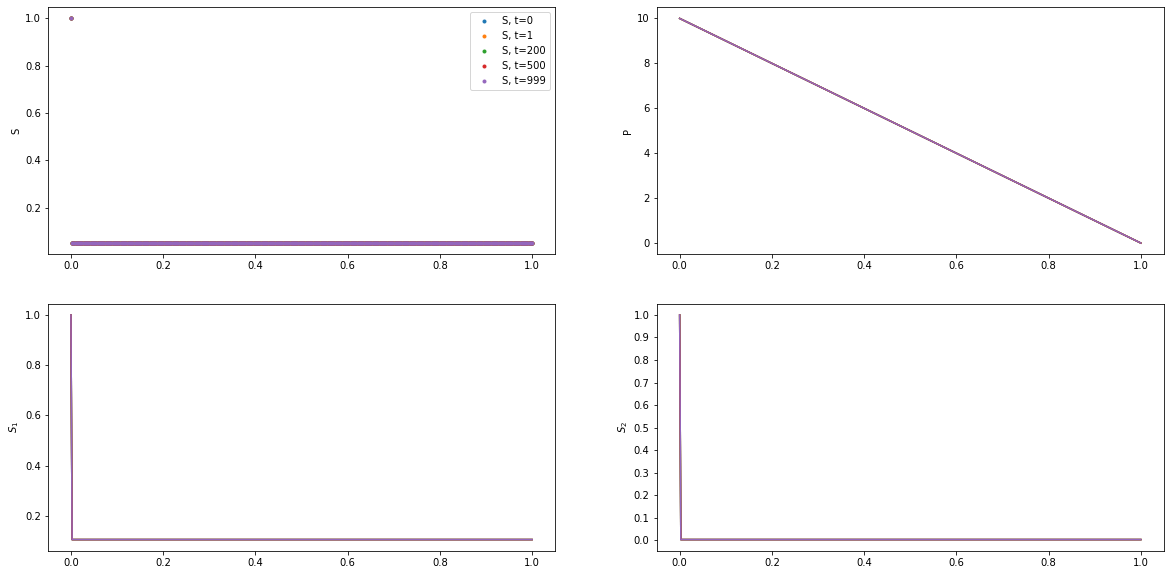

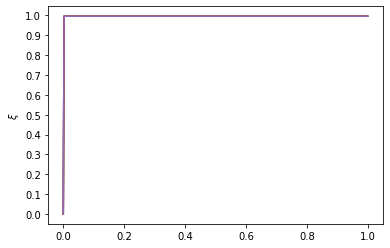

In [31]:
print('dt = {}'.format(dt))
print('tau_kondaurov =', tau_k)
print('tau_hassanizade =', tau_h)

fig, ax = plt.subplots(2,2, figsize=(20,10))
for i in [0, 1, 200, 500, 999, ]:
    ax[0, 0].plot(h_list, S_list[i], '.', label='S, t={}'.format(i))
#     ax[0, 0].scatter(0.2, b_debug, s=30, c='black')
    ax[0, 1].plot(h_list, P_list[i], '-', label='P')
    ax[1, 0].plot(h_list, [S1(S_list[i][j], ksi_list[i][j]) for j in range(len(S_list[i]))])
    ax[1, 1].plot(h_list, [S2(ksi_list[i][j]) for j in range(len(S_list[i]))])
ax[0, 0].set_ylabel('S')
ax[1, 0].set_ylabel('$S_1$')
ax[1, 1].set_ylabel('$S_2$')
ax[1, 1].set_yticks(np.arange(0, 1.1, 0.1))
ax[0, 1].set_ylabel('P')
ax[0, 0].legend()
plt.show()

for i in [0, 1, 200, 500, 999, ]:
    plt.plot(h_list, ksi_list[i])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('$\\xi$')
plt.show()

In [32]:
#save 4 report
hasnkondr_ksi = ksi_list
hasnkondr_S = S_list

## 6. Additional - то, о чем был разговор в пнд
Пусть 
* для уравнений на P & S $p_c = 0$
* $\xi$ - теперь задается равновесным уравнением $p_c^{(1)} = p_c^{(2)}$
* $\tau_h = 0$

In [95]:
# для некомплексности, необходимо будет в find_S подправить f1 & f2 = 0, т.к. мы требуем случай p_c = 0
# в функции S1 теперь должны быть соответствующие if
def S1(S, ksi):
    eq = (1+r)*S - r*(1-ksi)
    if eq < 0:
        return 0.0001
    if eq > 1:
        return 0.9999
    return eq
####################################################

## p_c == 0 ## 
tau_h = 0
# t = 0
S_list = [[1] + [0.05]*(len(h_list) - 1)]
ksi_list = [[get_ksi_equilibrium(S_list[0][i], 0) for i in range(len(h_list))]]
P_list = [find_P(S_list[0],
                 [None],
                 [0]*h_list,  #[p_c(S1(S_list[0][i], ksi_list[0][i]), 0, 0) for i in range(len(h_list))], #[0]*h_list,  #
                 ksi_list[0])]

for t_idx, t in enumerate(tqdm(t_list[1:1000])):
    p_c_n = [0]*len(h_list)  #[p_c(S1(S_list[t_idx][i], ksi_list[0][i]), 0, 0) for i in range(len(h_list))] # [0]*len(h_list)  #
    S_list.append(find_S(t, S_list[t_idx], P_list[t_idx], p_c_n, ksi_list[t_idx]))
    ksi_list.append([get_ksi_equilibrium(S_list[t_idx+1][i], t) for i in range(len(h_list))])
    P_list.append(find_P(S_list[t_idx+1], P_list[t_idx], p_c_n, ksi_list[t_idx]))

dt = 0.0001
tau_kondaurov = 0.0001
tau_hassanizade = 0


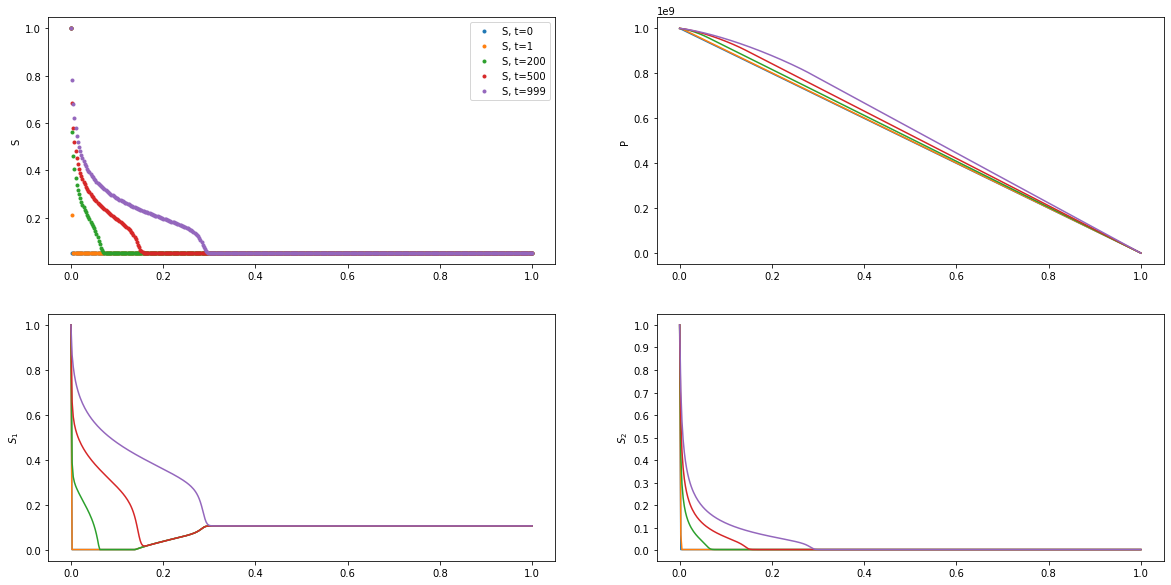

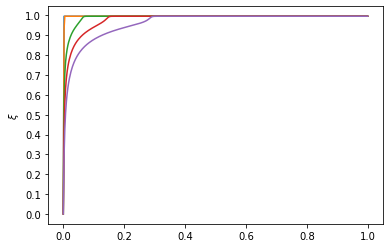

In [96]:
print('dt = {}'.format(dt))
print('tau_kondaurov =', tau_k)
print('tau_hassanizade =', tau_h)

fig, ax = plt.subplots(2,2, figsize=(20,10))
for i in [0, 1, 200, 500, 999, ]:
    ax[0, 0].plot(h_list, S_list[i], '.', label='S, t={}'.format(i))
#     ax[0, 0].scatter(0.2, b_debug, s=30, c='black')
    ax[0, 1].plot(h_list, P_list[i], '-', label='P')
    ax[1, 0].plot(h_list, [S1(S_list[i][j], ksi_list[t_idx][j]) for j in range(len(S_list[i]))])
    ax[1, 1].plot(h_list, [S2(ksi_list[i][j]) for j in range(len(S_list[i]))])
ax[0, 0].set_ylabel('S')
ax[1, 0].set_ylabel('$S_1$')
ax[1, 1].set_ylabel('$S_2$')
ax[1, 1].set_yticks(np.arange(0, 1.1, 0.1))
ax[0, 1].set_ylabel('P')
ax[0, 0].legend()
plt.show()

for i in [0, 1, 200, 500, 999, ]:
    plt.plot(h_list, ksi_list[i])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('$\\xi$')
plt.show()

## 7. Additional No2.
1. Составляем графики $p_c^{(1)}$ & $p_c^{(2)}$ зависящие от S:[0, 1]
2. Чтобы находить $S_1, S_2$ достаточно при текущем (выборочном) значении $p_c$, найти соответсвующие $p_c^{(1)}$ & $p_c^{(2)}$ точки на оси абсцис

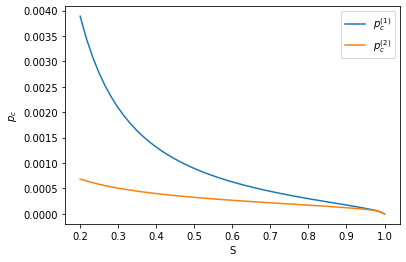

In [68]:
# n1, n2 = 2.68, 2.68#1.09, 2.68  # по модели ван генухтена (песок(2.68) и глина(1.09))
# m1, m2 = 2.9, 2.9#0.9, 2.9  # m = 1 - 1/n # подбирается, чтобы был участок с постоянным наклоном в графике p

_S = np.linspace(0.2, 1)
plt.plot(_S, [p_c1(S_) for S_ in _S], label='$p_c^{(1)}$')
plt.plot(_S, [p_c2(S_) for S_ in _S], label='$p_c^{(2)}$')
plt.xlabel('S')
plt.ylabel('$p_c$')
# plt.xticks(np.arange(-0.1, 1.1, 0.1))
plt.legend()

In [13]:
def find_S1_S2_via_p_c(p_c):
    def find_S1_equlibrium(S):
        return p_c - p_c1(S)
    def find_S2_equlibrium(S):
        return p_c - p_c2(S)

    root_S1 = root_scalar(find_S1_equlibrium, method='brentq', bracket=[0.0001, 1])
    root_S2 = root_scalar(find_S2_equlibrium, method='brentq', bracket=[0.0001, 1])
    return root_S1.root, root_S2.root

def find_ksi_via_S2(S2_):
    return 1 - S2_

def find_S_via_S1nS2(S1_, S2_):
    return phi1/phi*w1*S1_ + phi2/phi*w2*S2_

In [14]:
find_S1_S2_via_p_c(0.01)

(0.08126093009771075, 0.018098993137455433)

In [15]:
_p_c = np.linspace(0.01, 1)
_S1, _S2 = [find_S1_S2_via_p_c(p_c)[0] for p_c in _p_c], [find_S1_S2_via_p_c(p_c)[1] for p_c in _p_c]
_ksi = [find_ksi_via_S2(_S2[i]) for i in range(len(_S2))]
_S = [find_S_via_S1nS2(_S1[i], _S2[i]) for i in range(len(_S2))]
plt.plot(_S, _ksi, label='Monday schema', linewidth=5)
plt.xticks(np.arange(-0.1, 1.1, 0.1))
plt.grid()
plt.xlabel('S')
plt.ylabel('$\\xi$')
plt.plot(np.linspace(0.01, 1), [get_ksi_equilibrium(x, 0) for x in np.linspace(0.01, 1)], label='old schema')
plt.legend()

ValueError: f(a) and f(b) must have different signs

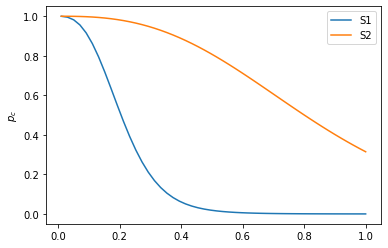

In [19]:
plt.plot(_p_c, _S1, label='S1')
plt.plot(_p_c, _S2, label='S2')
plt.ylabel('$p_c$')
plt.legend()

In [26]:
w1*phi1*_S1[-1] + w2*phi2*_S2[-1]

0.13689202591404448

# for reports

In [115]:
# start to compute all 3 models
...

dt = 0.0001
tau_h = 0.005
tau_k = 0.0001


Text(0.5, 0.98, 'Различные модели для момента времени t=0.050000')

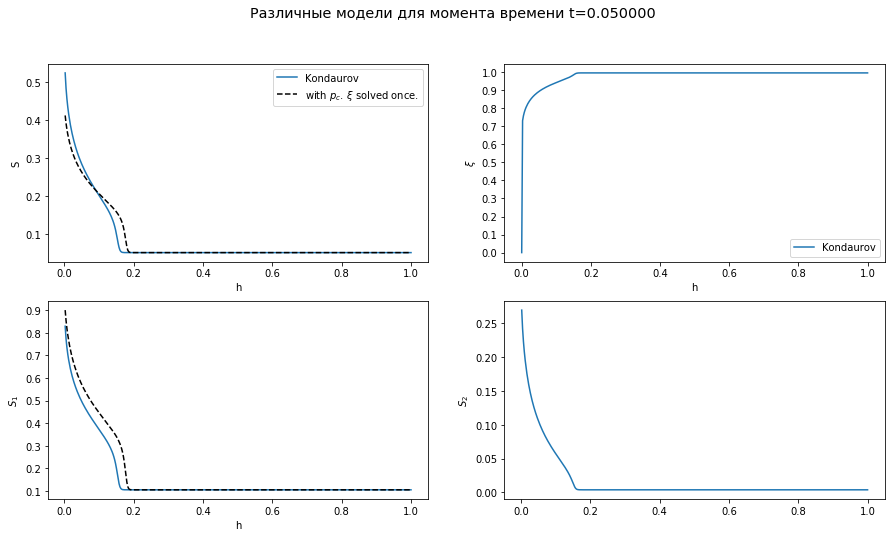

In [33]:
print('dt = {}'.format(dt))
print('tau_h =', tau_h)
print('tau_k =', tau_k)
h_list=np.linspace(0, 1, 400)
timel = [500]
fig, ax = plt.subplots(2,2, figsize=(15,8))
for time in timel:
#     ax[0,0].plot(h_list, ksionce_S[time], label='without $p_c$. $\\xi$ solved once. t={}'.format(time))
    ax[0,0].plot(h_list[1:], kond_S[time][1:], label='Kondaurov')
#     ax[0,0].plot(h_list, hasnkondr_S[time], label='Kondr + Hass')

    ax[0,1].plot(h_list, kond_ksi[time], label='Kondaurov')
#     ax[0,1].plot(h_list, hasnkondr_ksi[time], label='Kondr + Hass')
#     ax[1,0].plot(h_list, [S1(ksionce_S[time][i], ksionce_ksi[0][i]) for i in range(len(h_list))])
    ax[1,0].plot(h_list[1:], [S1(kond_S[time][i], kond_ksi[time][i]) for i in range(1,len(h_list))])
#     ax[1,0].plot(h_list, [S1(hasnkondr_S[time][i], hasnkondr_ksi[time][i]) for i in range(len(h_list))])
#     ax[1,1].plot(h_list, [S2(ksionce_ksi[0][i]) for i in range(len(h_list))])
    ax[1,1].plot(h_list[1:], [S2(kond_ksi[time][i]) for i in range(1,len(h_list))])
#     ax[1,1].plot(h_list, [S2(hasnkondr_ksi[time][i]) for i in range(len(h_list))])
    
    ax[0,0].plot(h_list[1:], pc_ksi_once_S[time][1:], '--', label='with $p_c$. $\\xi$ solved once.', color='black')
    ax[1,0].plot(h_list[1:], [S1(pc_ksi_once_S[time][i], pc_ksi_once_ksi[0][i]) for i in range(1,len(h_list))], '--', color='black')

ax[0,0].set_ylabel('S')
ax[1,0].set_ylabel('$S_1$')
ax[0,1].set_ylabel('$\\xi$')
ax[1,1].set_ylabel('$S_2$')
ax[0,0].set_xlabel('h')
ax[1,0].set_xlabel('h')
ax[0,1].set_xlabel('h')
ax[0,1].set_yticks(np.arange(0, 1.1, 0.1))
ax[0,0].legend()
# ax[1,0].legend()
ax[0,1].legend()
fig.suptitle('Различные модели для момента времени t={:.6f}'.format(dt*time), fontsize='x-large')

$$
    \frac{d \xi }{dt} = \frac{K}{tau_k} f(S, \xi)
$$

In [53]:
len(ksionce_S)

1000